# Feature selection

After manual overview of the data, and preparation of tuned Random Forest model, we will try to select the most important features, using several methods. We'll take the look on each predictions separately, and, in the same time, we'll create a general ranking, based on the number of times each feature was selected as important. Score of feature is calculated by the sum of ranks of each feature per each method. The lower the score, the better.

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

x_path = "data/x_train.txt"
y_path = "data/y_train.txt"

X = np.loadtxt(x_path)
y = np.loadtxt(y_path)

rf_best_features = {
    "random_state": 42,
    "n_estimators": 500,
    "max_depth": 15,
    "min_samples_split": 5,
    "min_samples_leaf": 1,
    "max_features": "sqrt",
    "bootstrap": True,
    "n_jobs": -1,
}

ranking = {}

## Random Forest Feature Importance

Random Forest contains a feature importance attribute by itself. It is calculated based on the average impurity decrease in the nodes where the feature is used. The impurity decrease is calculated as the difference between the impurity of the parent node and the sum of the child nodes. The impurity is calculated using the Gini impurity. The feature importance is normalized to sum up to 1.

In [5]:
rf = RandomForestClassifier(**rf_best_features)
rf.fit(X, y)

ranking["random_forest"] = np.zeros(X.shape[1])

for i, idx in enumerate(np.argsort(rf.feature_importances_)[::-1]):
    print(f"Feature {idx}: {rf.feature_importances_[idx]:.4f}")
    ranking["random_forest"][idx] = i

Feature 105: 0.0126
Feature 100: 0.0125
Feature 102: 0.0124
Feature 103: 0.0105
Feature 101: 0.0099
Feature 104: 0.0087
Feature 8: 0.0071
Feature 5: 0.0057
Feature 9: 0.0054
Feature 3: 0.0053
Feature 2: 0.0047
Feature 6: 0.0047
Feature 1: 0.0044
Feature 4: 0.0043
Feature 0: 0.0042
Feature 7: 0.0036
Feature 285: 0.0025
Feature 445: 0.0024
Feature 337: 0.0024
Feature 131: 0.0024
Feature 220: 0.0023
Feature 155: 0.0023
Feature 412: 0.0023
Feature 270: 0.0023
Feature 403: 0.0023
Feature 241: 0.0023
Feature 246: 0.0022
Feature 360: 0.0022
Feature 133: 0.0022
Feature 233: 0.0022
Feature 64: 0.0022
Feature 63: 0.0022
Feature 237: 0.0022
Feature 305: 0.0022
Feature 471: 0.0022
Feature 60: 0.0021
Feature 158: 0.0021
Feature 119: 0.0021
Feature 498: 0.0021
Feature 228: 0.0021
Feature 74: 0.0021
Feature 426: 0.0021
Feature 391: 0.0021
Feature 180: 0.0021
Feature 39: 0.0021
Feature 37: 0.0021
Feature 316: 0.0021
Feature 351: 0.0021
Feature 45: 0.0021
Feature 458: 0.0021
Feature 109: 0.0021
Feature

We have a confirmation of our believe that features 0-9 and 100-109 are the most important ones. However, while all the features from the first group are the top ones, feature 106-109 are much further. It may possibly indicate that those may not influence the prediction as well as others. Features 10-105 and 8 were especially high ranked. Importance coefficient for the rest was significantly lower.

## Maximal Information Coefficient

MIC is a non-parametric measure of the strength of the relationship between two variables. It can capture both linear and non-linear associations between features and the target variable. MIC is based on the concept of mutual information and can identify complex interactions.

In [6]:
from minepy import MINE

ranking["mic"] = np.zeros(X.shape[1])

mine = MINE(alpha=0.6, c=15)

mic_results = {}
for i in range(X.shape[1]):
    mine.compute_score(X[:, i], y)
    mic_results[i] = mine.mic()

sorted_mic_results = sorted(mic_results.items(), key=lambda x: x[1], reverse=True)
for i in range(X.shape[1]):
    print(f"Feature {sorted_mic_results[i][0]}: {sorted_mic_results[i][1]:.4f}")
    ranking["mic"][sorted_mic_results[i][0]] = i

Feature 101: 0.1029
Feature 102: 0.1024
Feature 105: 0.0988
Feature 100: 0.0987
Feature 8: 0.0962
Feature 103: 0.0947
Feature 5: 0.0944
Feature 104: 0.0944
Feature 9: 0.0933
Feature 0: 0.0918
Feature 6: 0.0897
Feature 4: 0.0890
Feature 492: 0.0870
Feature 1: 0.0865
Feature 351: 0.0858
Feature 2: 0.0855
Feature 191: 0.0851
Feature 167: 0.0849
Feature 106: 0.0843
Feature 239: 0.0843
Feature 114: 0.0842
Feature 3: 0.0842
Feature 296: 0.0841
Feature 366: 0.0840
Feature 7: 0.0840
Feature 328: 0.0840
Feature 256: 0.0839
Feature 360: 0.0835
Feature 456: 0.0832
Feature 373: 0.0832
Feature 168: 0.0831
Feature 187: 0.0831
Feature 234: 0.0831
Feature 161: 0.0830
Feature 48: 0.0829
Feature 451: 0.0829
Feature 152: 0.0828
Feature 370: 0.0828
Feature 222: 0.0827
Feature 367: 0.0827
Feature 180: 0.0826
Feature 136: 0.0825
Feature 471: 0.0825
Feature 251: 0.0825
Feature 375: 0.0824
Feature 75: 0.0824
Feature 120: 0.0823
Feature 385: 0.0823
Feature 335: 0.0822
Feature 77: 0.0822
Feature 403: 0.0822
Fea

Once again features from groups 0-9 and 100-109 are highly ranked. However, MIC does not return that diverse ranking as Random Forest. Result between the consecutive features is more consistent.

## SHAP

SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. It connects game theory with local explanations, uniting several previous methods and representing the only possible consistent and locally accurate additive feature attribution method based on expectations.

In [7]:
import shap

ranking["shap"] = np.zeros(X.shape[1])

rf = RandomForestClassifier(**rf_best_features)
rf.fit(X, y)

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

shap_results = {}
for i in range(X.shape[1]):
    shap_results[i] = np.abs(shap_values[:, i, 0]).mean(0)

sorted_results = sorted(shap_results.items(), key=lambda x: x[1], reverse=True)
for i in range(X.shape[1]):
    print(f"Feature {sorted_results[i][0]}: {sorted_results[i][1]:.4f}")
    ranking["shap"][sorted_results[i][0]] = i

/opt/homebrew/Caskroom/miniconda/base/envs/advanced-ml/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Feature 105: 0.0114
Feature 102: 0.0111
Feature 100: 0.0102
Feature 103: 0.0093
Feature 101: 0.0087
Feature 104: 0.0078
Feature 8: 0.0065
Feature 5: 0.0057
Feature 9: 0.0050
Feature 3: 0.0047
Feature 6: 0.0042
Feature 1: 0.0038
Feature 7: 0.0038
Feature 4: 0.0038
Feature 2: 0.0037
Feature 0: 0.0033
Feature 412: 0.0019
Feature 285: 0.0018
Feature 328: 0.0016
Feature 64: 0.0014
Feature 458: 0.0014
Feature 139: 0.0013
Feature 403: 0.0012
Feature 303: 0.0012
Feature 220: 0.0012
Feature 351: 0.0012
Feature 155: 0.0012
Feature 131: 0.0012
Feature 323: 0.0011
Feature 252: 0.0011
Feature 39: 0.0011
Feature 321: 0.0010
Feature 498: 0.0010
Feature 422: 0.0010
Feature 489: 0.0010
Feature 35: 0.0010
Feature 270: 0.0010
Feature 60: 0.0010
Feature 21: 0.0010
Feature 335: 0.0010
Feature 445: 0.0009
Feature 360: 0.0009
Feature 337: 0.0009
Feature 484: 0.0009
Feature 63: 0.0009
Feature 204: 0.0009
Feature 74: 0.0009
Feature 24: 0.0009
Feature 84: 0.0009
Feature 462: 0.0008
Feature 34: 0.0008
Feature 73

SHAP have very similar results to Random Forest. This comes as no surprise as this method main goal is to explain the output of Random Forest model. 

## XBGoost Feature Importance

Similar to Random Forest, XGBoost also contains a feature importance attribute. It is calculated based on the average gain of the feature when it is used in trees. The gain is calculated as the improvement in accuracy brought by a feature to the branches it is used in. The feature importance is normalized to sum up to 1.

In [8]:
import xgboost as xgb

ranking["xgboost"] = np.zeros(X.shape[1])

xgboost = xgb.XGBClassifier(nthread=-1)
xgboost.fit(X, y)

for i, idx in enumerate(np.argsort(xgboost.feature_importances_)[::-1]):
    print(f"Feature {idx}: {xgboost.feature_importances_[idx]:.4f}")
    ranking["xgboost"][idx] = i

Feature 8: 0.0071
Feature 100: 0.0066
Feature 302: 0.0065
Feature 102: 0.0064
Feature 105: 0.0056
Feature 101: 0.0055
Feature 103: 0.0053
Feature 278: 0.0052
Feature 343: 0.0050
Feature 99: 0.0048
Feature 104: 0.0048
Feature 370: 0.0046
Feature 441: 0.0046
Feature 205: 0.0040
Feature 354: 0.0038
Feature 59: 0.0037
Feature 130: 0.0037
Feature 475: 0.0037
Feature 345: 0.0037
Feature 78: 0.0036
Feature 151: 0.0036
Feature 416: 0.0036
Feature 484: 0.0036
Feature 107: 0.0036
Feature 126: 0.0035
Feature 458: 0.0035
Feature 3: 0.0035
Feature 327: 0.0035
Feature 1: 0.0035
Feature 453: 0.0034
Feature 387: 0.0034
Feature 238: 0.0034
Feature 297: 0.0034
Feature 346: 0.0033
Feature 280: 0.0033
Feature 47: 0.0033
Feature 26: 0.0033
Feature 371: 0.0032
Feature 282: 0.0032
Feature 17: 0.0032
Feature 9: 0.0032
Feature 166: 0.0032
Feature 220: 0.0032
Feature 432: 0.0032
Feature 437: 0.0032
Feature 319: 0.0031
Feature 192: 0.0031
Feature 494: 0.0031
Feature 221: 0.0031
Feature 70: 0.0031
Feature 301: 0.

XGBoosting has quite different results than rest methods so far. Feature 8 was selected over the group  100-105 and some features outside of 2 main groups (0-9 and 100-105) were selected as important. Those are feature 302, 278 and 343.

## Boruta

The Boruta algorithm is a feature selection method that iteratively compares the importance of each feature to the importance of randomly permuted shadow features. It uses a random forest classifier to estimate feature importances and selects features that have significantly higher importance than the shadow features. Boruta iteratively removes irrelevant features until only the relevant ones remain, providing a subset of informative features for further analysis. Since BorutaPy is incompatible with the used version of numpy, we will use the custom implementation of the algorithm.

In [9]:
def boruta_feature_importance(rf, X, y, max_iter=50):
    # Initialize the feature importance array
    n_features = X.shape[1]
    feature_importance = np.zeros(n_features)

    # Iterate until the maximum number of iterations is reached
    for _ in range(max_iter):
        # Create shadow features by shuffling the values of each feature
        shadow_features = np.array(
            [np.random.permutation(X[:, i]) for i in range(n_features)]
        ).T

        # Combine the original features and shadow features
        X_extended = np.hstack((X, shadow_features))

        # Fit the random forest classifier on the extended dataset
        rf.fit(X_extended, y)

        # Get the feature importances
        importances = rf.feature_importances_

        # Update the feature importance scores
        feature_importance += importances[:n_features]

    # Normalize the feature importance scores
    feature_importance /= max_iter

    return feature_importance


rf = RandomForestClassifier(**rf_best_features)
feature_importance = boruta_feature_importance(rf, X, y)

ranking["boruta"] = np.zeros(X.shape[1])

for i, idx in enumerate(np.argsort(feature_importance)[::-1]):
    print(f"Feature {idx}: {feature_importance[idx]:.4f}")
    ranking["boruta"][idx] = i

Feature 102: 0.0087
Feature 105: 0.0081
Feature 100: 0.0077
Feature 103: 0.0068
Feature 101: 0.0065
Feature 8: 0.0052
Feature 104: 0.0051
Feature 5: 0.0037
Feature 3: 0.0036
Feature 9: 0.0034
Feature 2: 0.0032
Feature 0: 0.0030
Feature 6: 0.0030
Feature 1: 0.0029
Feature 4: 0.0026
Feature 7: 0.0026
Feature 403: 0.0013
Feature 285: 0.0013
Feature 270: 0.0012
Feature 220: 0.0012
Feature 351: 0.0012
Feature 360: 0.0012
Feature 64: 0.0012
Feature 155: 0.0012
Feature 412: 0.0012
Feature 323: 0.0012
Feature 39: 0.0012
Feature 328: 0.0012
Feature 498: 0.0012
Feature 74: 0.0011
Feature 335: 0.0011
Feature 458: 0.0011
Feature 252: 0.0011
Feature 129: 0.0011
Feature 139: 0.0011
Feature 108: 0.0011
Feature 60: 0.0011
Feature 109: 0.0011
Feature 133: 0.0011
Feature 471: 0.0011
Feature 281: 0.0011
Feature 321: 0.0011
Feature 57: 0.0011
Feature 215: 0.0011
Feature 439: 0.0011
Feature 204: 0.0011
Feature 489: 0.0011
Feature 63: 0.0011
Feature 241: 0.0011
Feature 357: 0.0011
Feature 211: 0.0011
Featur

Once again, features 100-105 leading, with features 0-9 being right after.

## Recursive Feature Elimination

RFE is a feature selection method that fits a model and removes the weakest feature (or features) until the specified number of features is reached. It is based on the idea that the best subset of features is the one that minimizes the error of the model. We will use the tuned Random Forest model as the estimator.

In [10]:
from sklearn.feature_selection import RFE

ranking["rfe"] = np.zeros(X.shape[1])

rfe = RFE(
    estimator=RandomForestClassifier(**rf_best_features),
    step=1,
    verbose=1,
    n_features_to_select=1,
)
rfe.fit(X, y)

for i, idx in enumerate(np.argsort(rfe.ranking_)):
    print(f"Feature {idx}: {rfe.ranking_[idx]}")
    ranking["rfe"][idx] = i

Fitting estimator with 500 features.
Fitting estimator with 499 features.
Fitting estimator with 498 features.
Fitting estimator with 497 features.
Fitting estimator with 496 features.
Fitting estimator with 495 features.
Fitting estimator with 494 features.
Fitting estimator with 493 features.
Fitting estimator with 492 features.
Fitting estimator with 491 features.
Fitting estimator with 490 features.
Fitting estimator with 489 features.
Fitting estimator with 488 features.
Fitting estimator with 487 features.
Fitting estimator with 486 features.
Fitting estimator with 485 features.
Fitting estimator with 484 features.
Fitting estimator with 483 features.
Fitting estimator with 482 features.
Fitting estimator with 481 features.
Fitting estimator with 480 features.
Fitting estimator with 479 features.
Fitting estimator with 478 features.
Fitting estimator with 477 features.
Fitting estimator with 476 features.
Fitting estimator with 475 features.
Fitting estimator with 474 features.
F

RFE provided very interesting results. While features 100-105 are still leading, rankings of features 0-9 were distributed by some other ones, most notably feature 371 and 113. However, consistently, feature 8 is just behind the 100-105 group.

## ReliefF

ReliefF is a feature selection algorithm that evaluates the importance of features by considering the difference between the nearest instances of the same and different classes. It is a simple and efficient algorithm that can handle both continuous and discrete features.

In [11]:
from skrebate import ReliefF

ranking["relief"] = np.zeros(X.shape[1])

relief = ReliefF(n_neighbors=0.2, n_jobs=-1)
relief.fit(X, y)

for i, idx in enumerate(np.argsort(relief.feature_importances_)[::-1]):
    print(f"Feature {idx}: {relief.feature_importances_[idx]:.4f}")
    ranking["relief"][idx] = i

Feature 105: 0.0019
Feature 8: 0.0019
Feature 102: 0.0018
Feature 101: 0.0018
Feature 100: 0.0016
Feature 3: 0.0015
Feature 9: 0.0014
Feature 2: 0.0014
Feature 103: 0.0013
Feature 6: 0.0012
Feature 5: 0.0012
Feature 1: 0.0012
Feature 7: 0.0010
Feature 0: 0.0010
Feature 4: 0.0009
Feature 104: 0.0009
Feature 328: 0.0009
Feature 303: 0.0009
Feature 321: 0.0008
Feature 351: 0.0008
Feature 323: 0.0007
Feature 285: 0.0007
Feature 374: 0.0006
Feature 211: 0.0006
Feature 287: 0.0005
Feature 339: 0.0005
Feature 288: 0.0004
Feature 215: 0.0004
Feature 220: 0.0004
Feature 249: 0.0004
Feature 252: 0.0004
Feature 360: 0.0004
Feature 157: 0.0004
Feature 270: 0.0004
Feature 208: 0.0004
Feature 240: 0.0004
Feature 391: 0.0004
Feature 317: 0.0004
Feature 462: 0.0003
Feature 316: 0.0003
Feature 335: 0.0003
Feature 484: 0.0003
Feature 309: 0.0003
Feature 372: 0.0003
Feature 383: 0.0003
Feature 200: 0.0003
Feature 329: 0.0003
Feature 297: 0.0003
Feature 403: 0.0003
Feature 415: 0.0003
Feature 210: 0.0003


And once again, feature 8 and group 100-105 are leading. From the 100-105 group, feature 104 scored worst.

## Final ranking

And we finally collected the feature importances for each of the methods selected by us. Let's see the final ranking.

In [12]:
final_ranking = np.sum(list(ranking.values()), axis=0)
print(f"Methods: {list(ranking.keys())}")

for i in np.argsort(final_ranking):
    print(f"Feature {i}: {final_ranking[i]}")

Methods: ['random_forest', 'mic', 'shap', 'xgboost', 'boruta', 'rfe', 'relief']
Feature 105: 8.0
Feature 102: 9.0
Feature 100: 16.0
Feature 101: 24.0
Feature 8: 28.0
Feature 103: 30.0
Feature 104: 53.0
Feature 9: 88.0
Feature 3: 93.0
Feature 6: 114.0
Feature 1: 130.0
Feature 0: 211.0
Feature 4: 292.0
Feature 484: 307.0
Feature 403: 316.0
Feature 2: 319.0
Feature 220: 340.0
Feature 458: 344.0
Feature 360: 376.0
Feature 328: 400.0
Feature 351: 480.0
Feature 5: 484.0
Feature 412: 507.0
Feature 270: 524.0
Feature 391: 539.0
Feature 462: 541.0
Feature 7: 579.0
Feature 316: 589.0
Feature 39: 611.0
Feature 303: 620.0
Feature 323: 637.0
Feature 131: 667.0
Feature 215: 667.0
Feature 321: 671.0
Feature 335: 676.0
Feature 155: 681.0
Feature 139: 695.0
Feature 285: 698.0
Feature 366: 716.0
Feature 252: 719.0
Feature 152: 727.0
Feature 498: 728.0
Feature 64: 735.0
Feature 199: 761.0
Feature 133: 762.0
Feature 24: 766.0
Feature 21: 774.0
Feature 249: 788.0
Feature 241: 792.0
Feature 237: 802.0
Featu

In line with previous results, features 100-105 are leading, followed by features 0-9. The leader is feature 105, followed by 102 and 100. From the 2nd group the most notable is feature 8. Let's take a look at top positions of each method separately, as we could see that most of the methods lead to very similar results, possibly omitting some interesting features. Remember that in our data exploration, we found that features 100-109, as well as 0-9, follows very similar distribution, and indicated a correlation among them. That may mean that we could use only one of the features from each group, and still achieve a good result, as the while taking some other features into account, which contain not redundant information.

In [49]:
import pandas as pd

top_20_features = {}

for method, ranks in ranking.items():
    top_20_features[method] = np.argsort(ranks)[:20]

top_20_features["ensemble"] = np.argsort(final_ranking)[:20]
pd.DataFrame(top_20_features, index=np.arange(1, 21))

,random_forest,mic,shap,xgboost,boruta,rfe,relief,ensemble
1,105,101,105,8,102,102,105,105
2,100,102,102,100,105,105,8,102
3,102,105,100,302,100,103,102,100
4,103,100,103,102,103,100,101,101
5,101,8,101,105,101,101,100,8
6,104,103,104,101,8,104,3,103
7,8,5,8,103,104,8,9,104
8,5,104,5,278,5,6,2,9
9,9,9,9,343,3,371,103,3
10,3,0,3,99,9,9,6,6


Now we may see that as expected, groups 0-9 and 100-105 are leading. There are also features 285, 328, 351, and, 403 which appeared in top 20 for more than one method.

## Data analysis on top features

We will analyze features 0-9, 100-105 and 285, 328, 351, 371, 403 in the next step alone, to analyze their nature once again in the smaller context.

In [46]:
selected_features = np.concatenate(
    (np.arange(0, 10), np.arange(100, 106), np.array([285, 328, 351, 403]))
)
X_reduced = X[:, selected_features]
X_reduced_df = pd.DataFrame(X_reduced, columns=selected_features)
X_reduced_df.head()

X_reduced_df["target"] = y

### Correlation matrix

We will create a correlation matrix for the top features, to see if there are any strong correlations between them.

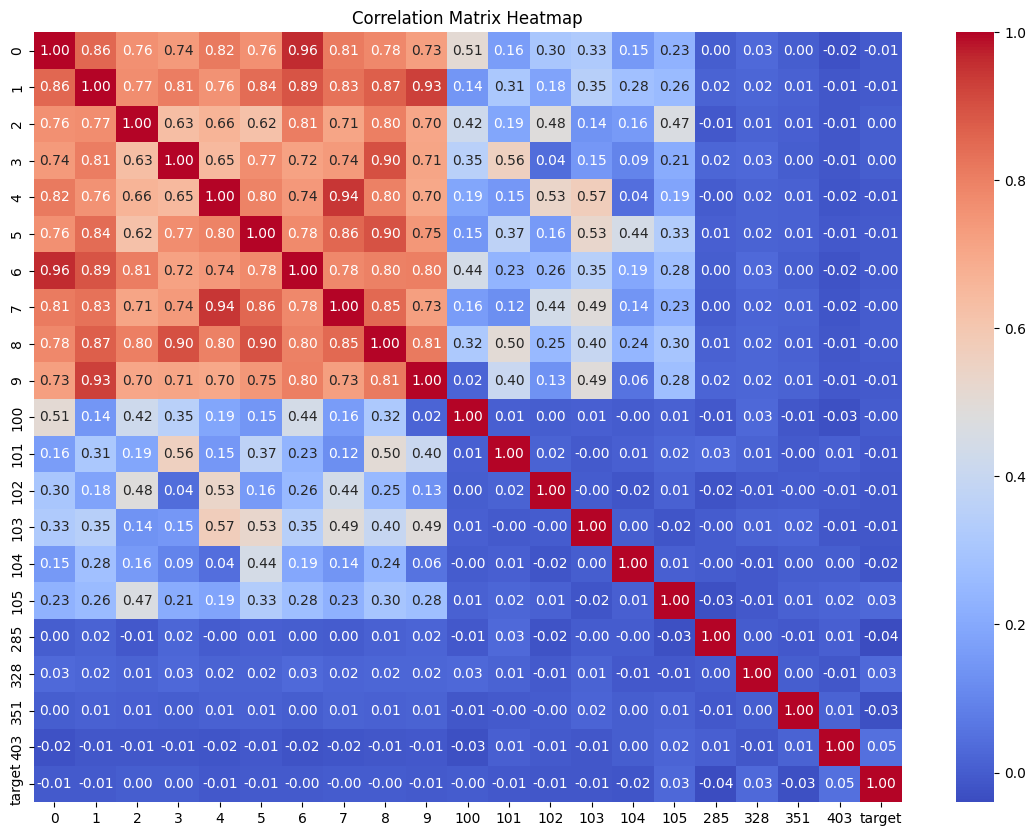

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = X_reduced_df.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()


While this extra variables outside of groups 0-9 and 100-105 are not correlated with the rest of the features at all, we can see moderate correlation between features 100-105 and very high correlation between features 0-9. This indicate that group 0-9 can be easily reduced and, it comes out that the feature 8 has the highest correlation with the rest of the group (with the lowest correlation coefficient of 0.78). Combining this knowledge with high position in rankings, feature 8 seems as perfect candidate to be used as a representative of the group. And there is no clear correlation with the target variable.

### Multicollinearity

Now, let's go back once again to the multicollinearity analysis, to see if the top features will still get infinite VIF, meaning they can be described by the rest of the features, now in the context of the top features only.

In [25]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X_reduced_with_target = X_reduced_df.to_numpy()

vif = np.array(
    [
        variance_inflation_factor(X_reduced_with_target, i)
        for i in range(X_reduced_with_target.shape[1])
    ]
)

for i, idx in enumerate(X_reduced_df.columns):
    print(f"Feature {idx}: {vif[i]:.2f}")

/opt/homebrew/Caskroom/miniconda/base/envs/advanced-ml/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Feature 0: inf
Feature 1: inf
Feature 2: inf
Feature 3: inf
Feature 4: inf
Feature 5: inf
Feature 6: inf
Feature 7: inf
Feature 8: inf
Feature 9: inf
Feature 100: inf
Feature 101: inf
Feature 102: inf
Feature 103: inf
Feature 104: inf
Feature 105: inf
Feature 285: 3.19
Feature 328: 3.24
Feature 351: 3.19
Feature 403: 4.11
Feature target: 1.89


Once again infitine VIF scores for features from group 0-9 and 100-105. Let's see if this will hold when only features from single group will be taken into account. Unfortunately, it holds that target features cannot be linearly described by the rest of the features.

In [26]:
X_temp = X[:, np.arange(0, 10)]
vif = np.array([variance_inflation_factor(X_temp, i) for i in range(X_temp.shape[1])])
print("Group 0-9")
for i, idx in enumerate(np.arange(0, 10)):
    print(f"Feature {idx}: {vif[i]:.2f}")

X_temp = X[:, np.arange(100, 106)]
vif = np.array([variance_inflation_factor(X_temp, i) for i in range(X_temp.shape[1])])
print("Group 100-105")
for i, idx in enumerate(np.arange(100, 106)):
    print(f"Feature {idx}: {vif[i]:.2f}")

Group 0-9
Feature 0: 221.51
Feature 1: 64.28
Feature 2: 15.06
Feature 3: 42.17
Feature 4: 127.06
Feature 5: 22.49
Feature 6: 147.60
Feature 7: 73.14
Feature 8: 102.71
Feature 9: 48.86
Group 100-105
Feature 100: 1.00
Feature 101: 1.00
Feature 102: 1.00
Feature 103: 1.00
Feature 104: 1.00
Feature 105: 1.00


And, it come out, that those two groups are somehow related too. While there is still high multicollinearity between features 0-9, features 100-105 are completly independend in terms of multicollinearity (VIF = 1).

## Summary

Based on our feature selection we pick the following features: 8, 100-105 and 285, 328, 351, 403. We will use them in the next stage where we will pick the best combination out of them directly on the score basis.